# Investigating GW x Galaxy cross-correlations

In this notebook, we will attempt to reproduce the results obtained in [this paper](https://arxiv.org/abs/1603.02356).

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from src.angular_power_spectra import CrossPowerSpectra, RedshiftBin
from src.matter_power_spectrum import CAMBInterface

We fix the fiducial cosmology with parameters from Planck 2018. We compute the matter power spectrum with `CAMB`:

Note: redshifts have been re-sorted (earliest first)


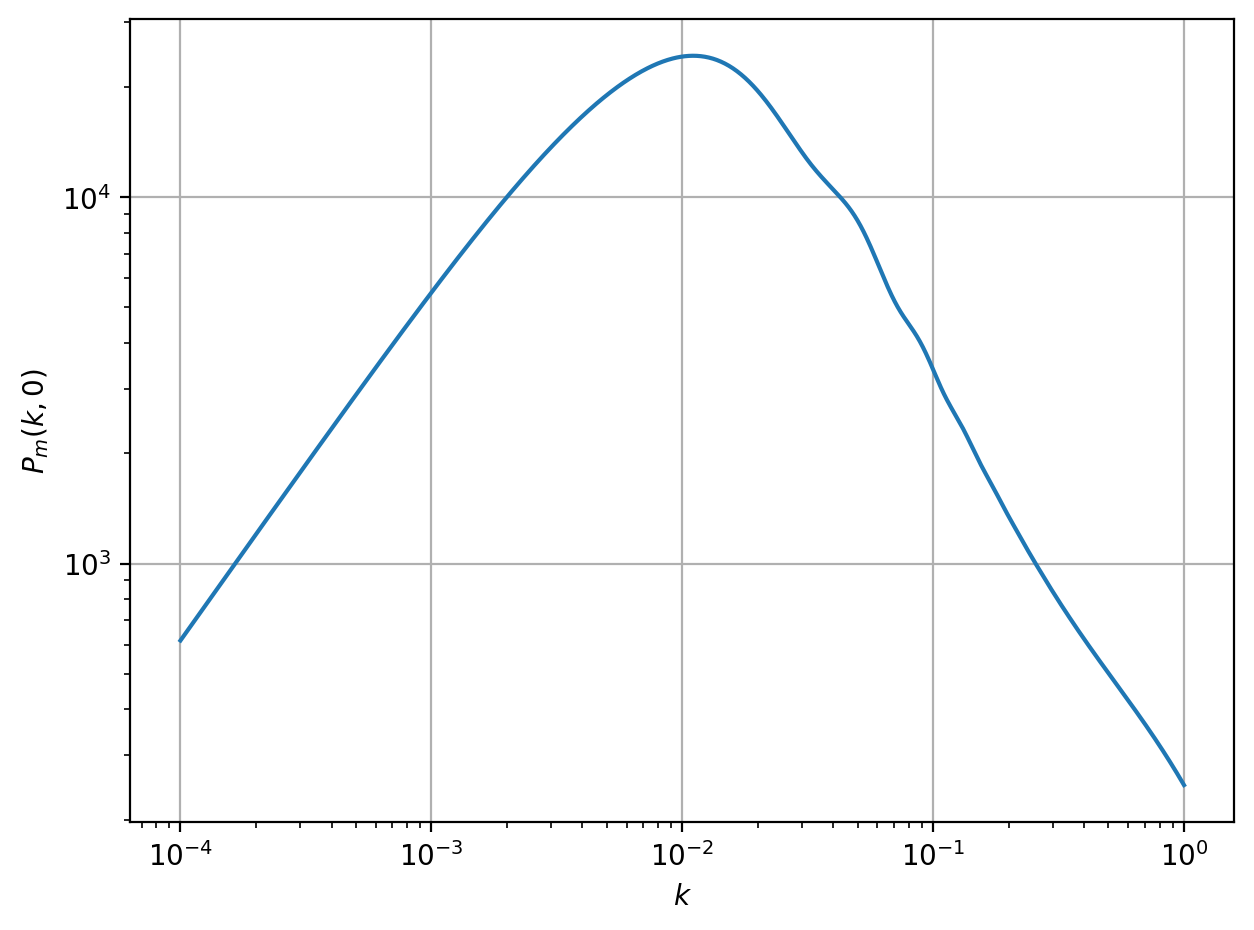

In [2]:
zmin = 1e-4
zmax = 2.
npoints = 1000
z = np.linspace(zmin, zmax, npoints)
k = np.logspace(-4, 0, npoints)
camb_interface = CAMBInterface(zmin, zmax)
camb_interface.run_solver()
pm = camb_interface.matter_power_spectrum_interpolator().P

fig, ax = plt.subplots()
ax.plot(k, pm(0, k))
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P_m(k, 0)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
fig.tight_layout()
plt.show()

In [4]:
nbins = 10
zbins = np.linspace(zmin, zmax, nbins)
bins = [RedshiftBin(zbins[i], zbins[i + 1]) for i in range(nbins - 1)]
cp = CrossPowerSpectra(z, bins, pm=pm)

In [5]:
l = 100
print(cp.cgigj(l, bins[5], bins[6], z, bg=1))

AttributeError: 'FlatLambdaCDM' object has no attribute 'comomving_distance'